<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stock_Price_anomaly_detection_Using_Stupid_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#!nvidia-smi

In [19]:
#!pip install gdown
#!pip install tensorflow-gpu
!pip install yfinance

In [20]:
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 15

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [21]:
#!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [22]:
ticker = '^NSEI'
#!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
START = "2007-01-01"  #yyyy-mm-dd
df = yf.download(ticker, start=START)
df = df.dropna()
#df = df.iloc[:,:4]
#df = df.resample('W').close()
df.head(3)
data = df.copy()

[*********************100%***********************]  1 of 1 completed


In [23]:
#df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [24]:
df = df[['Close']]
#df.head()

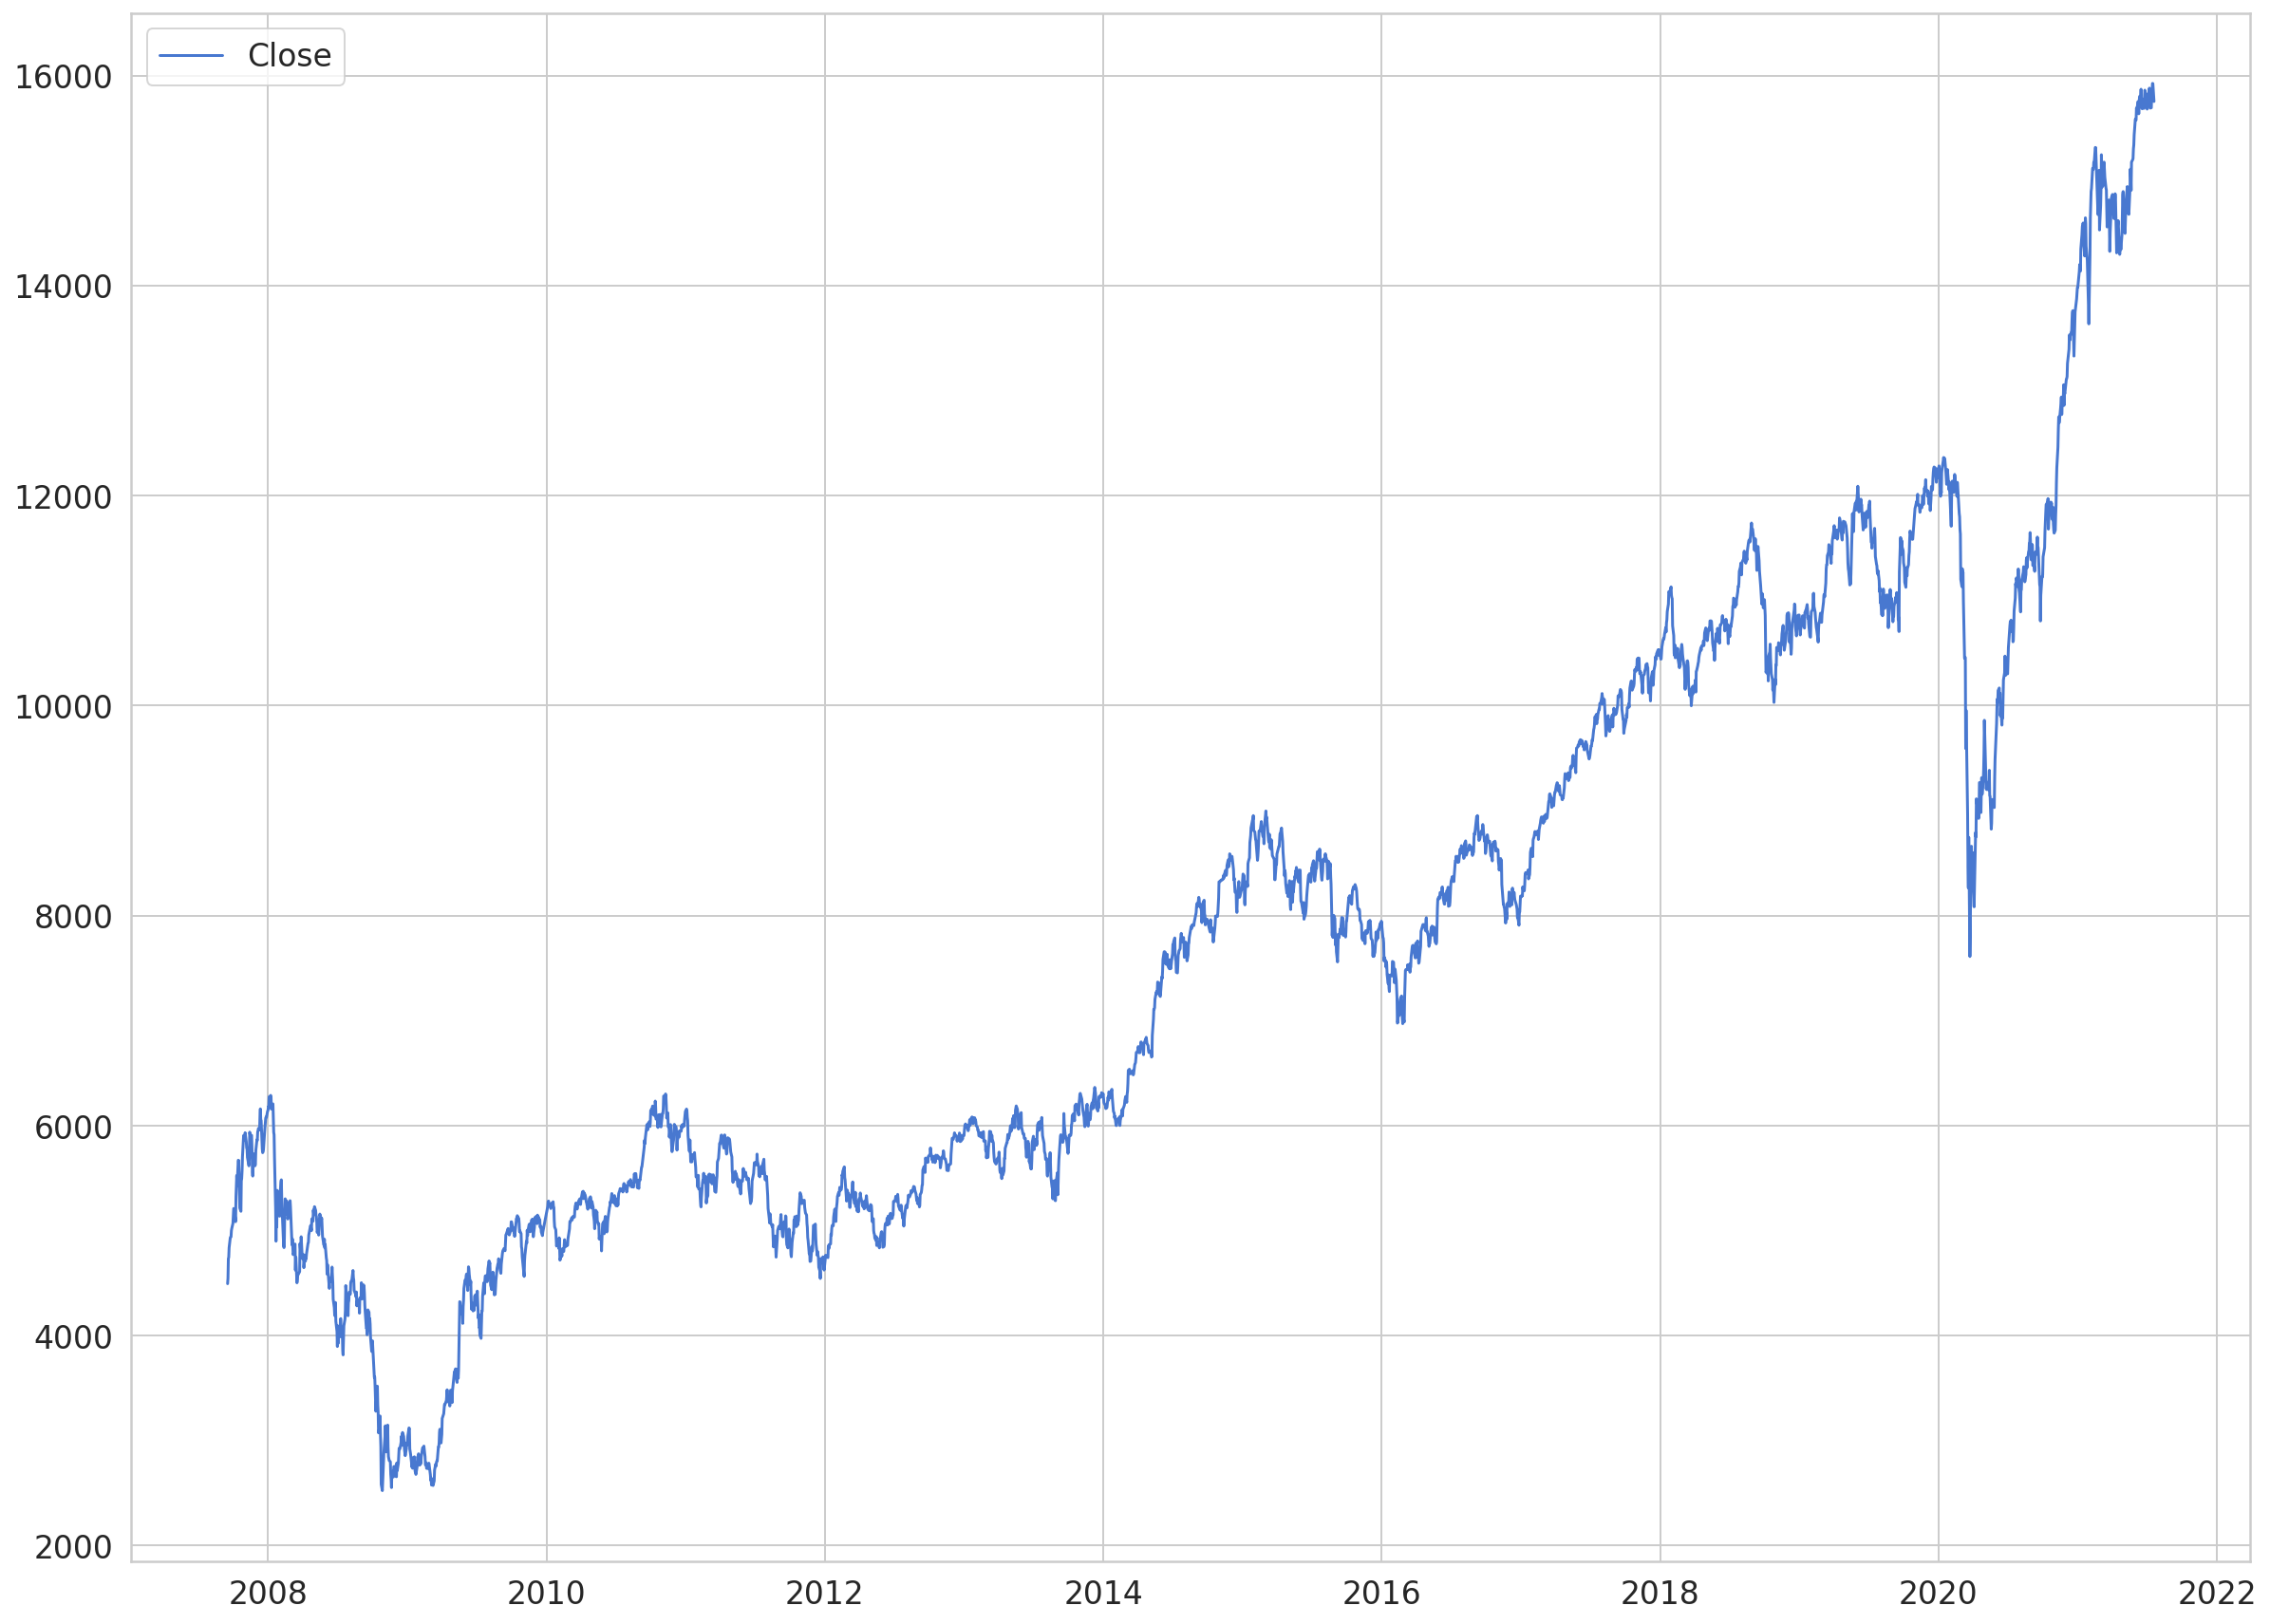

In [25]:
plt.plot(df, label='Close')
plt.legend();

In [26]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2704, 1) (677, 1)


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [28]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Close']], train.Close, TIME_STEPS)
X_test, y_test = create_dataset(test[['Close']], test.Close, TIME_STEPS)

print(X_train.shape)

(2694, 10, 1)


In [30]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
76/76 [==============================] - 6s 27ms/step - loss: 0.2954 - val_loss: 0.3944
Epoch 2/10
76/76 [==============================] - 1s 15ms/step - loss: 0.2061 - val_loss: 0.2017
Epoch 3/10
76/76 [==============================] - 1s 16ms/step - loss: 0.1691 - val_loss: 0.1689
Epoch 4/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1201 - val_loss: 0.1628
Epoch 5/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1371 - val_loss: 0.1026
Epoch 6/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1396 - val_loss: 0.1278
Epoch 7/10
76/76 [==============================] - 1s 16ms/step - loss: 0.1189 - val_loss: 0.0810
Epoch 8/10
76/76 [==============================] - 1s 16ms/step - loss: 0.0922 - val_loss: 0.0742
Epoch 9/10
76/76 [==============================] - 1s 16ms/step - loss: 0.1120 - val_loss: 0.0827
Epoch 10/10
76/76 [==============================] - 1s 15ms/step - loss: 0.0911 - val_loss: 0.0577


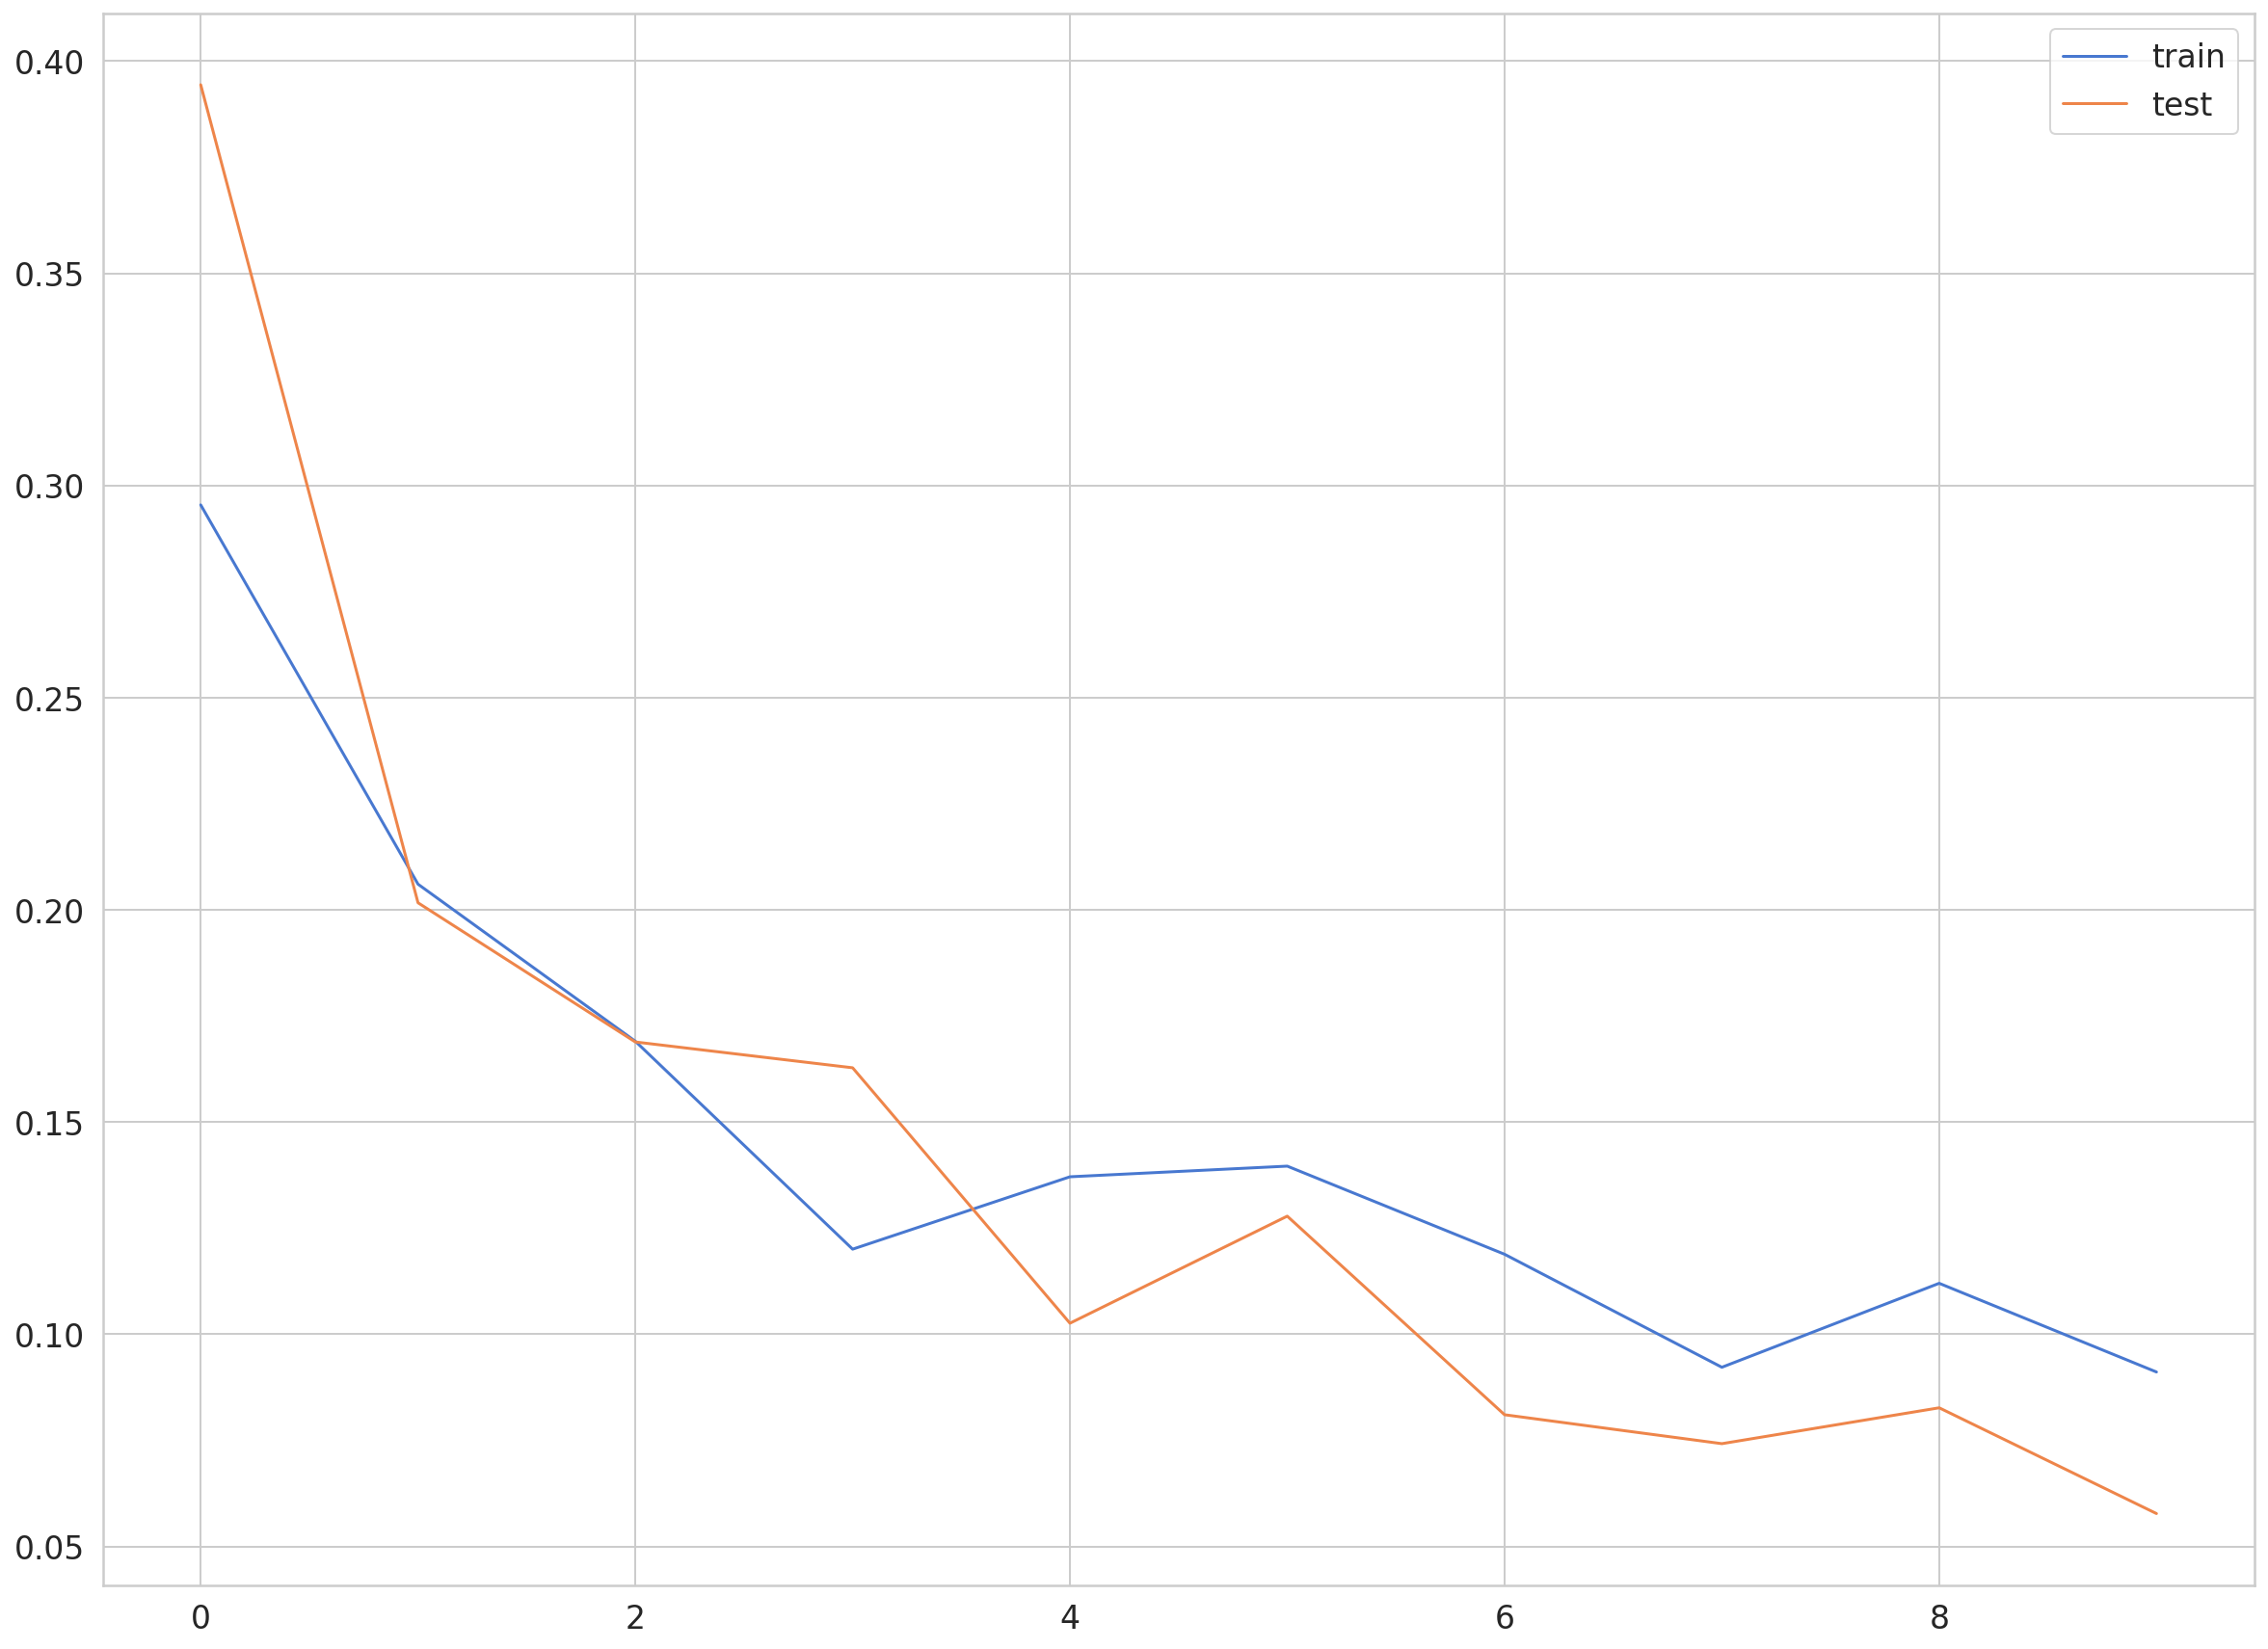

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [33]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


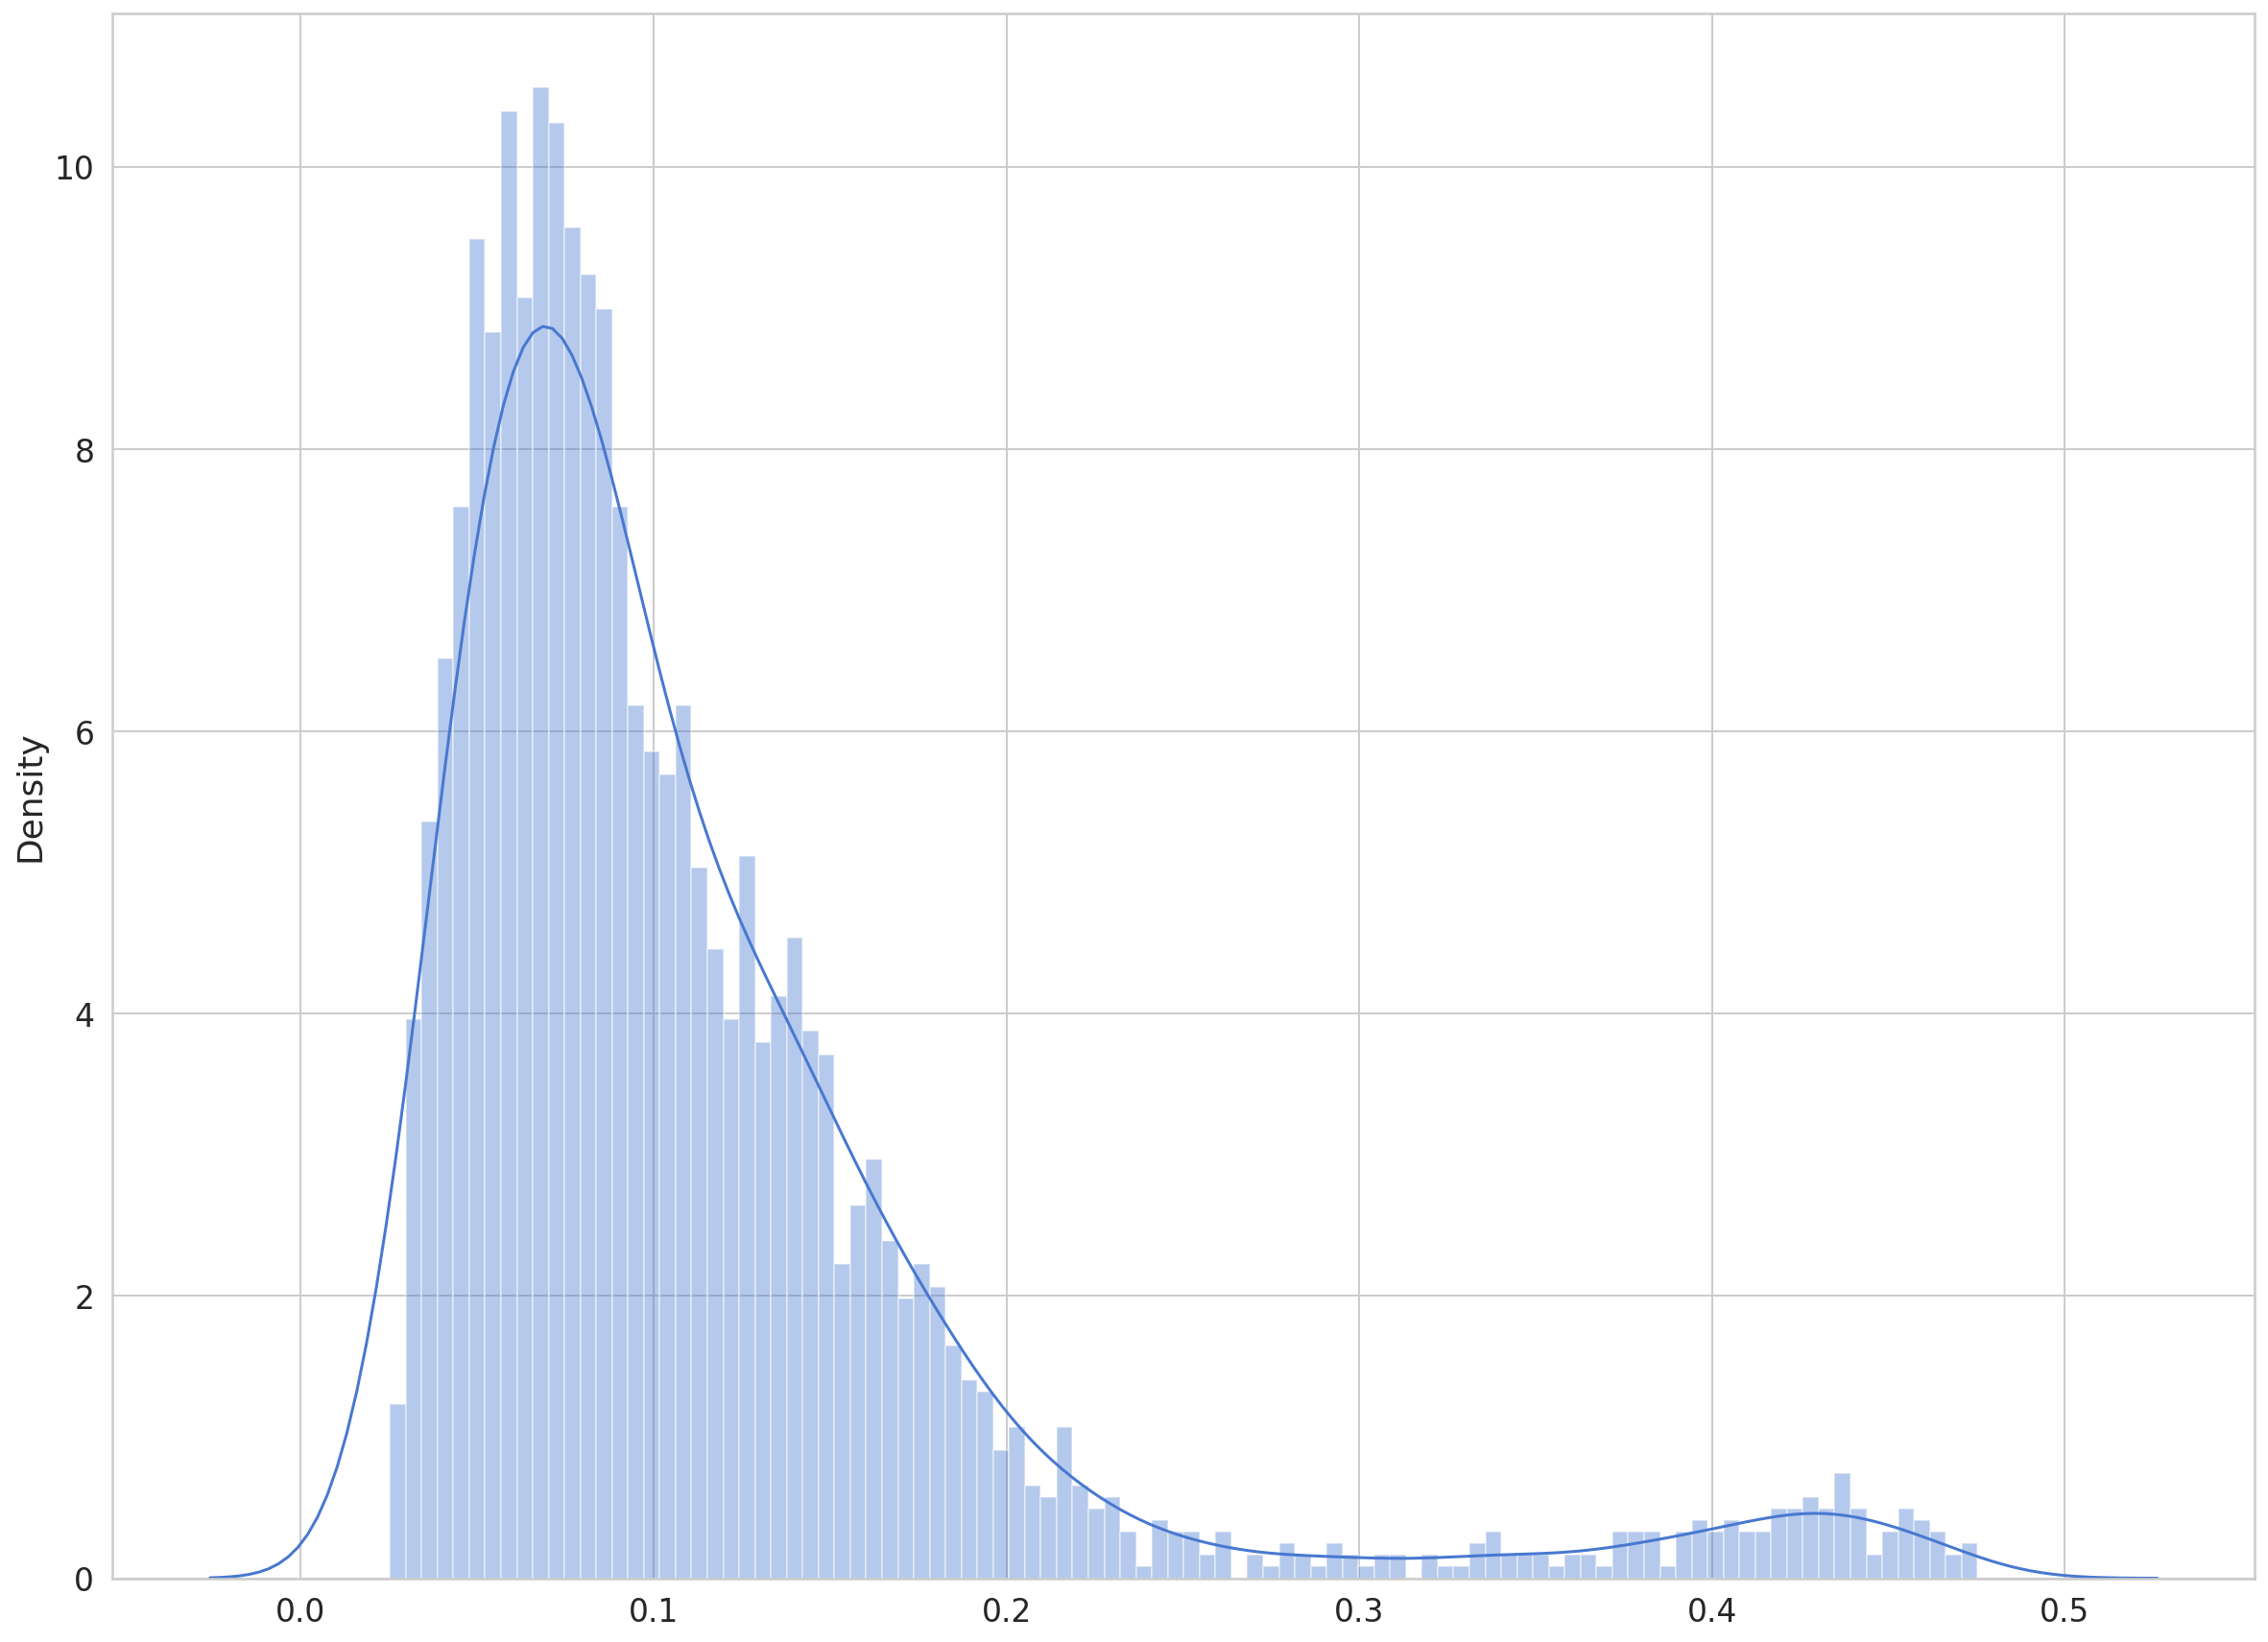

In [34]:
sns.distplot(train_mae_loss, bins=100, kde=True);

In [35]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [44]:

THRESHOLDSHORT = 0  # CHANGE THIS

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['thresholdSHORT'] = THRESHOLDSHORT
test_score_df['anomalySHORT'] = test_score_df.loss < test_score_df.thresholdSHORT 
test_score_df['Close'] = test[TIME_STEPS:].Close

In [45]:
test_score_df.head(2)

,loss,thresholdSHORT,anomalySHORT,Close
Date,,,,
2018-10-30,0.070240,0,False,1.680129
2018-10-31,0.065007,0,False,1.770116


In [46]:
THRESHOLDLONG = .4 # CHANGE THIS

#test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['thresholdLONG'] = THRESHOLDLONG
test_score_df['anomalyLONG'] = test_score_df.loss > test_score_df.thresholdLONG  
test_score_df['Close'] = test[TIME_STEPS:].Close

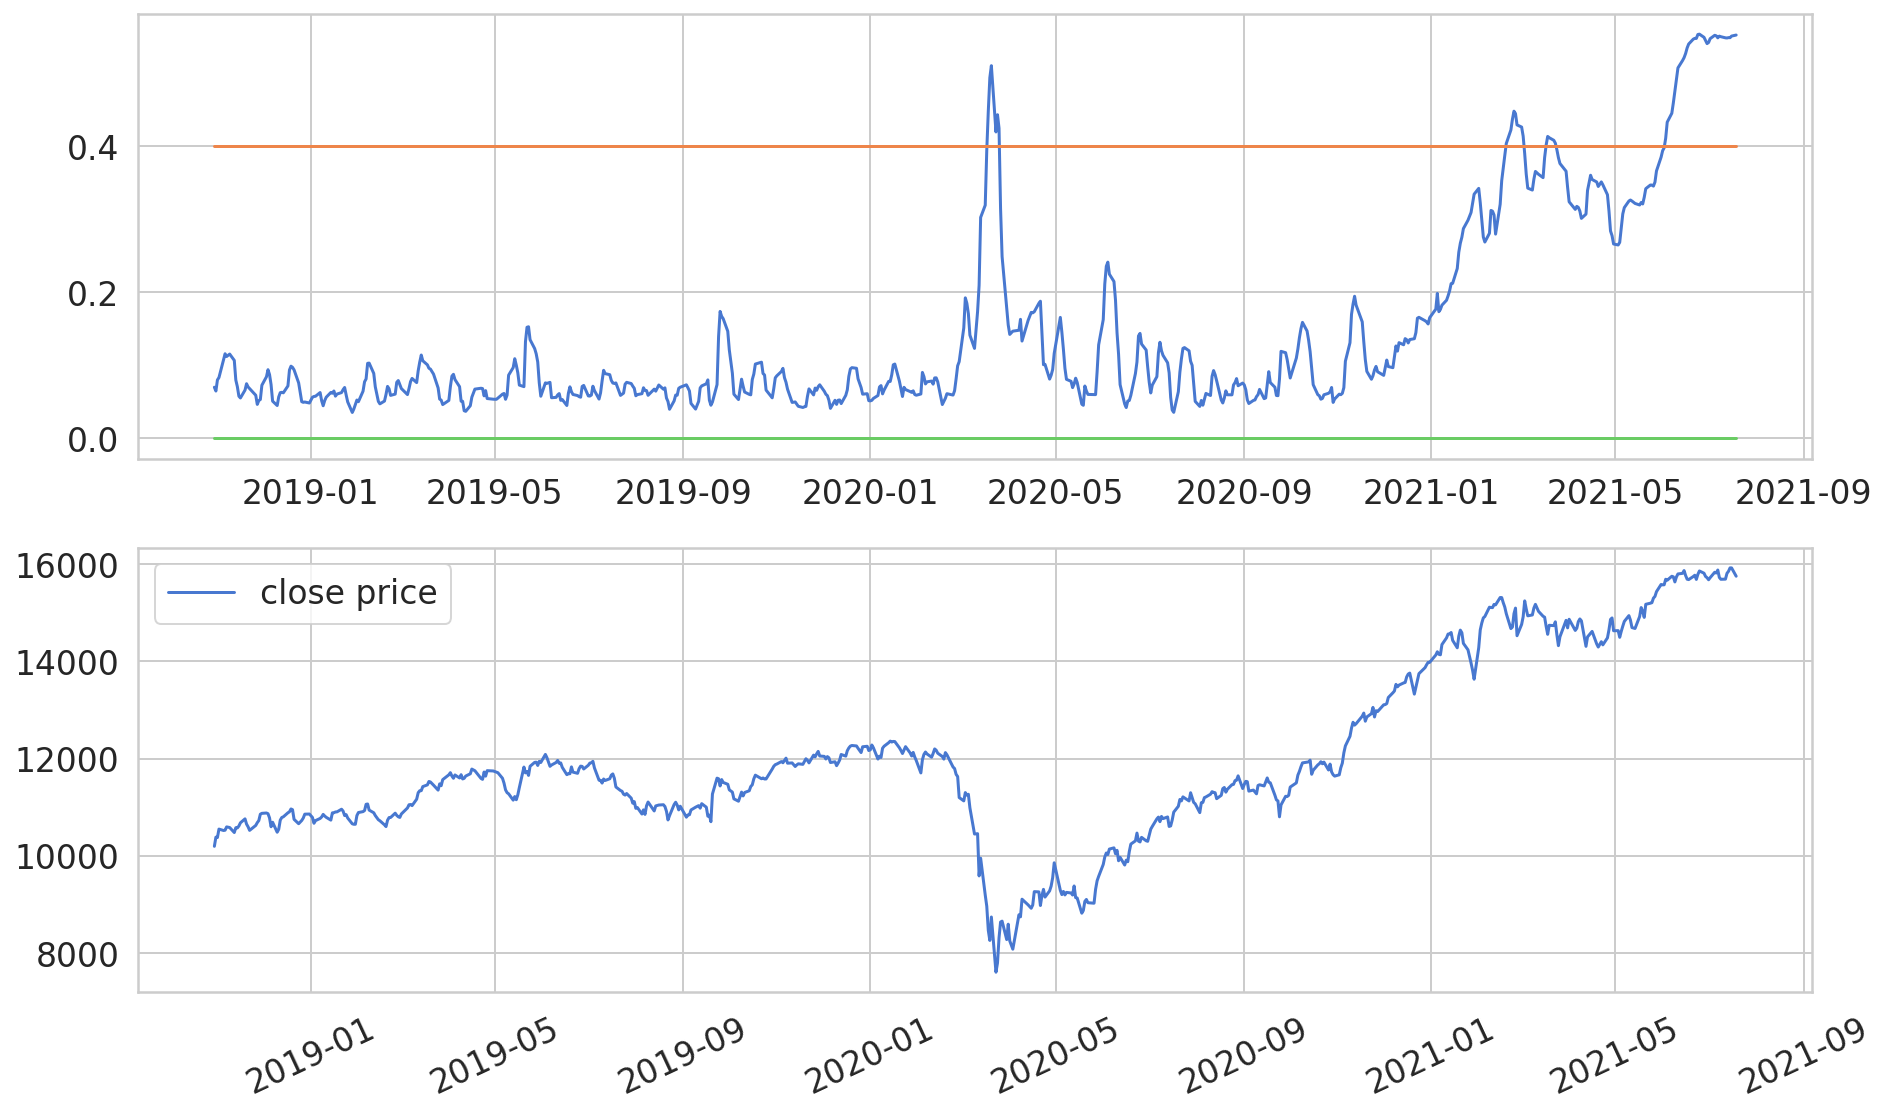

In [47]:
fig, ax = plt.subplots(2,1,figsize=(15,9))
ax[0].plot(test_score_df.index, test_score_df.loss, label='loss')
ax[0].plot(test_score_df.index, test_score_df.thresholdLONG, label='thresholdLONG')
ax[0].plot(test_score_df.index, test_score_df.thresholdSHORT, label='thresholdSHORT')
ax[1].plot(test[TIME_STEPS:].index,scaler.inverse_transform(test[TIME_STEPS:].Close),label='close price')
plt.xticks(rotation=25)
plt.legend();

In [48]:
temp = test_score_df[['loss','thresholdLONG','Close','anomalyLONG']]
anomaliesL = temp[temp.anomalyLONG == True]
anomaliesL.tail()

,loss,thresholdLONG,Close,anomalyLONG
Date,,,,
2021-07-13,0.548471,0.4,4.364426,True
2021-07-14,0.548967,0.4,4.384317,True
2021-07-15,0.548895,0.4,4.417907,True
2021-07-16,0.551084,0.4,4.417524,True
2021-07-19,0.552488,0.4,4.335761,True


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


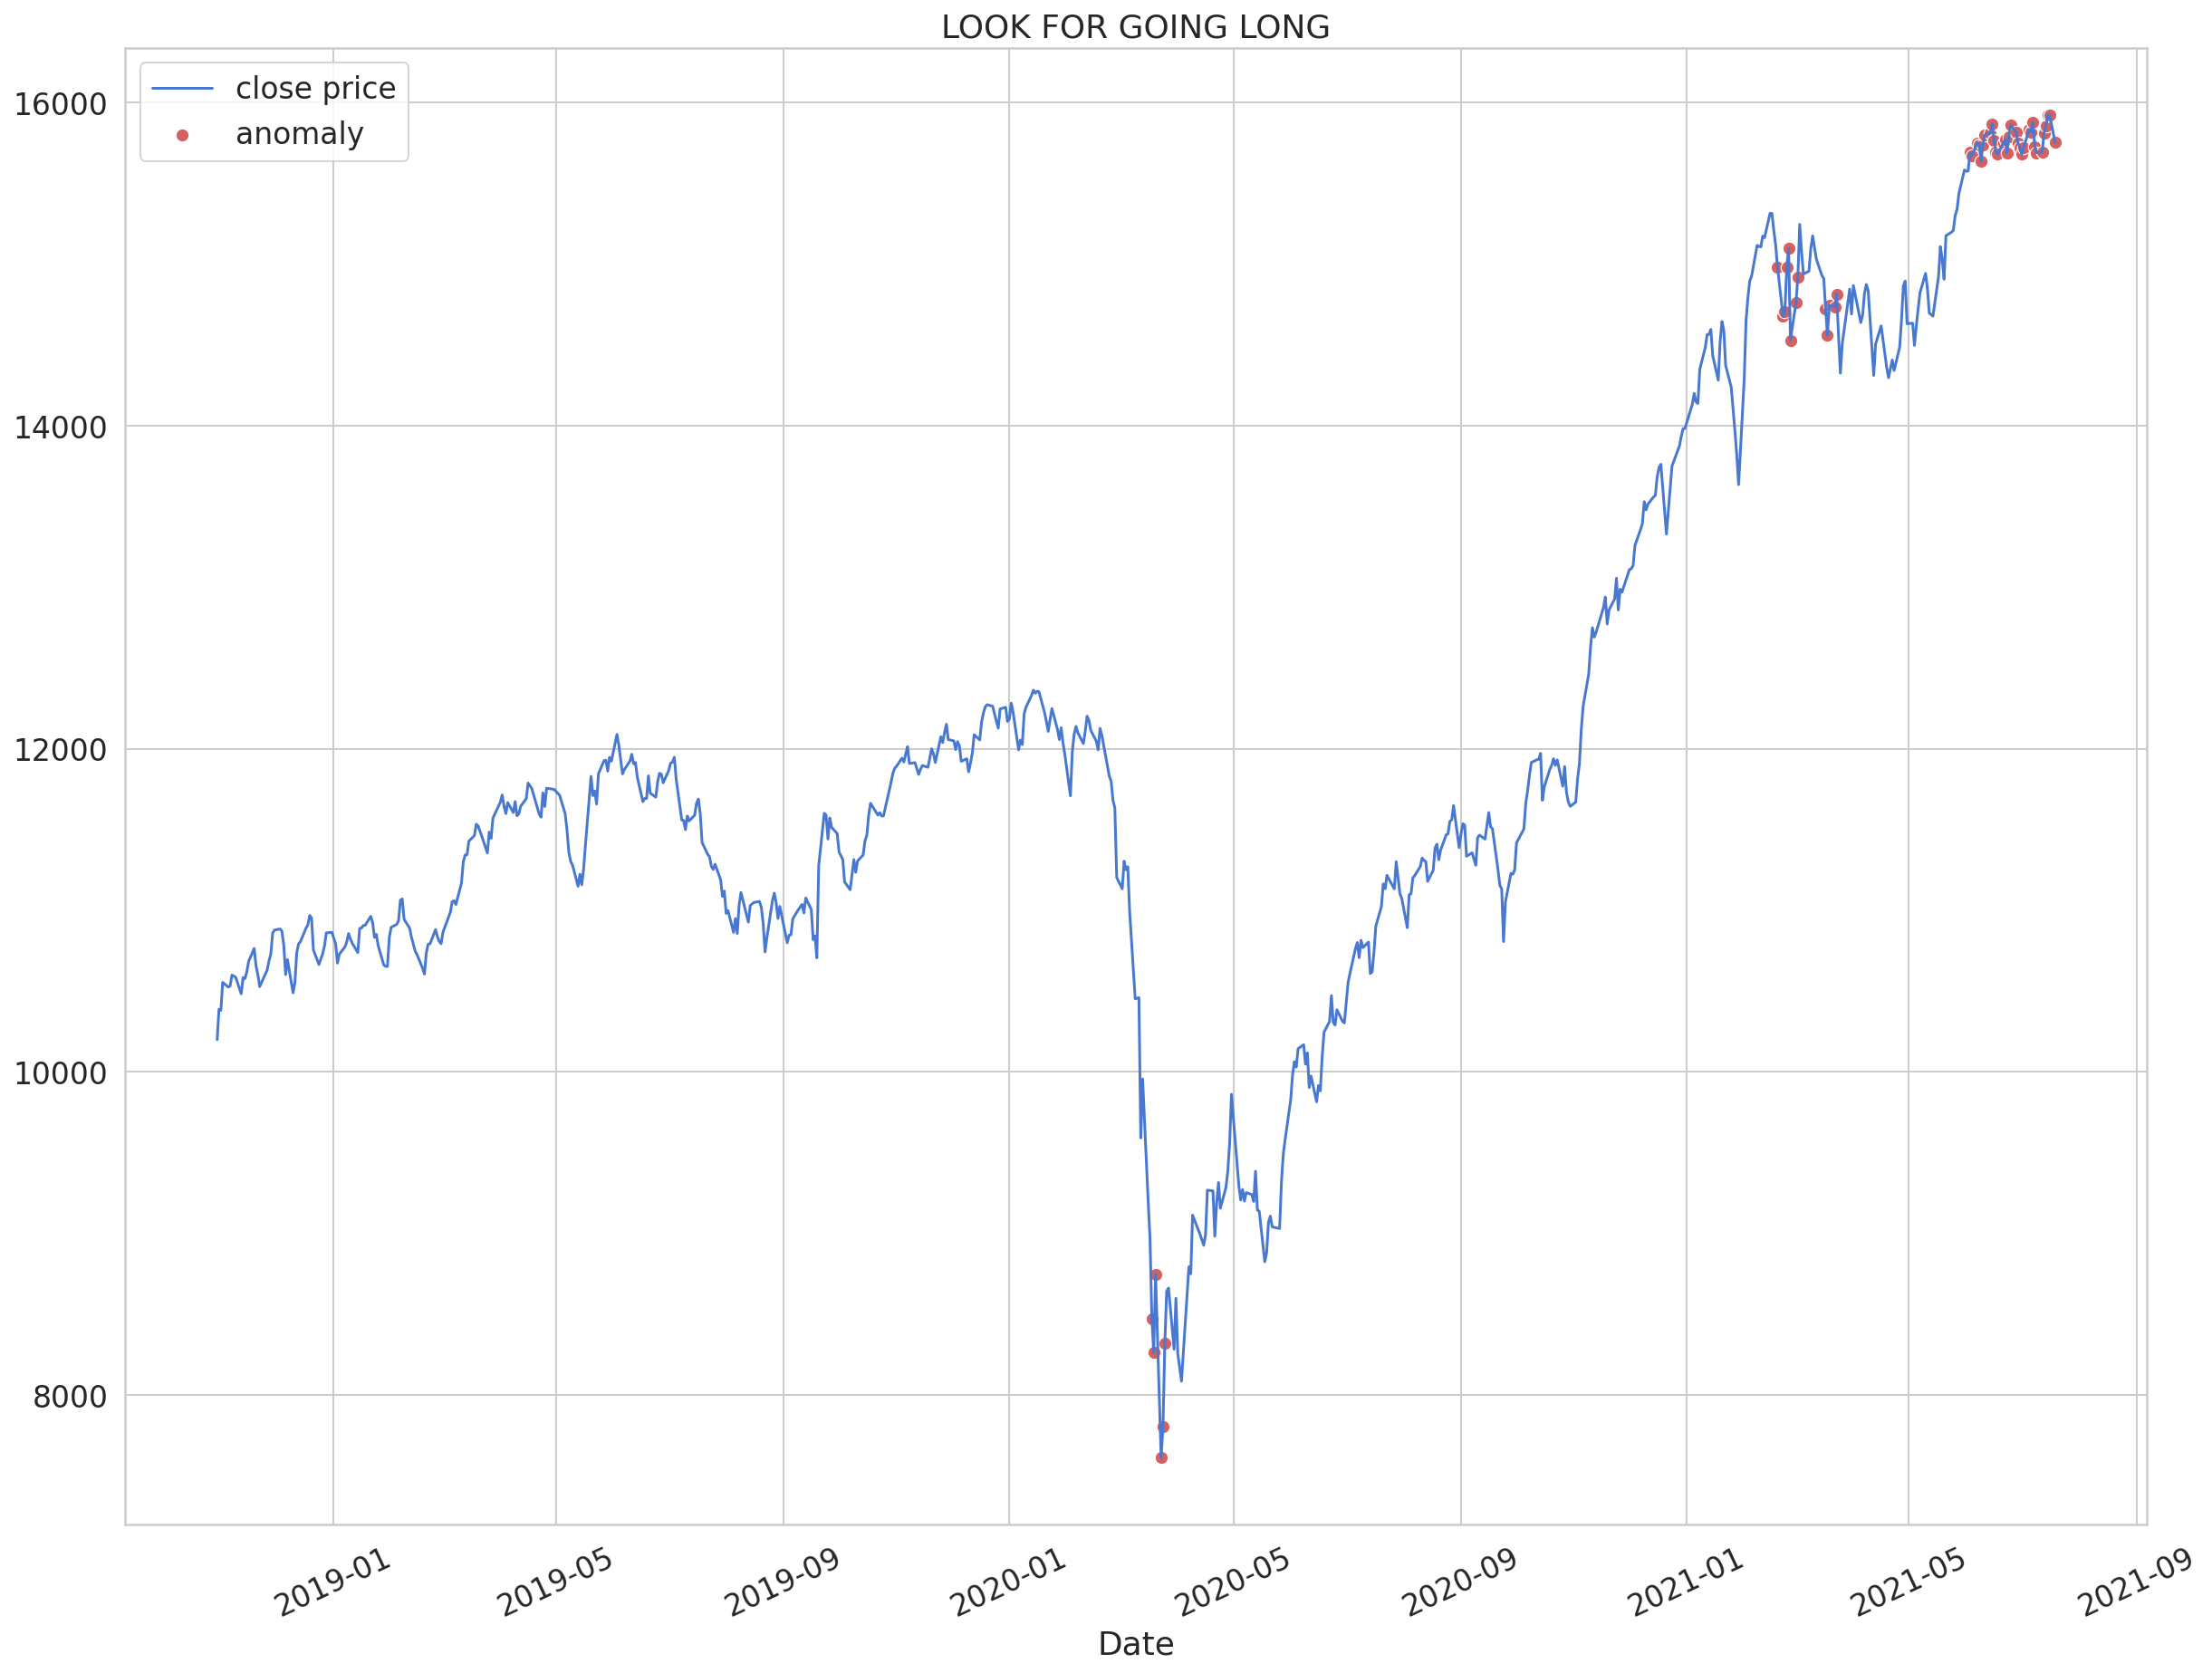

In [49]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
);

sns.scatterplot(
  anomaliesL.index,
  scaler.inverse_transform(anomaliesL.Close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.savefig('anamolyLONG.png', dpi=150)
plt.title('LOOK FOR GOING LONG')
plt.legend();

In [42]:
temp_1 = test_score_df[['loss','thresholdSHORT','Close','anomalySHORT']]
anomaliesS = temp_1[temp_1.anomalySHORT == True]
anomaliesS.head()

,loss,thresholdSHORT,Close,anomalySHORT
Date,,,,
2018-10-30,0.070240,0.08,1.680129,True
2018-10-31,0.065007,0.08,1.770116,True
2018-11-14,0.070984,0.08,1.860821,True
2018-11-15,0.057954,0.08,1.880138,True
2018-11-16,0.055493,0.08,1.911457,True


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


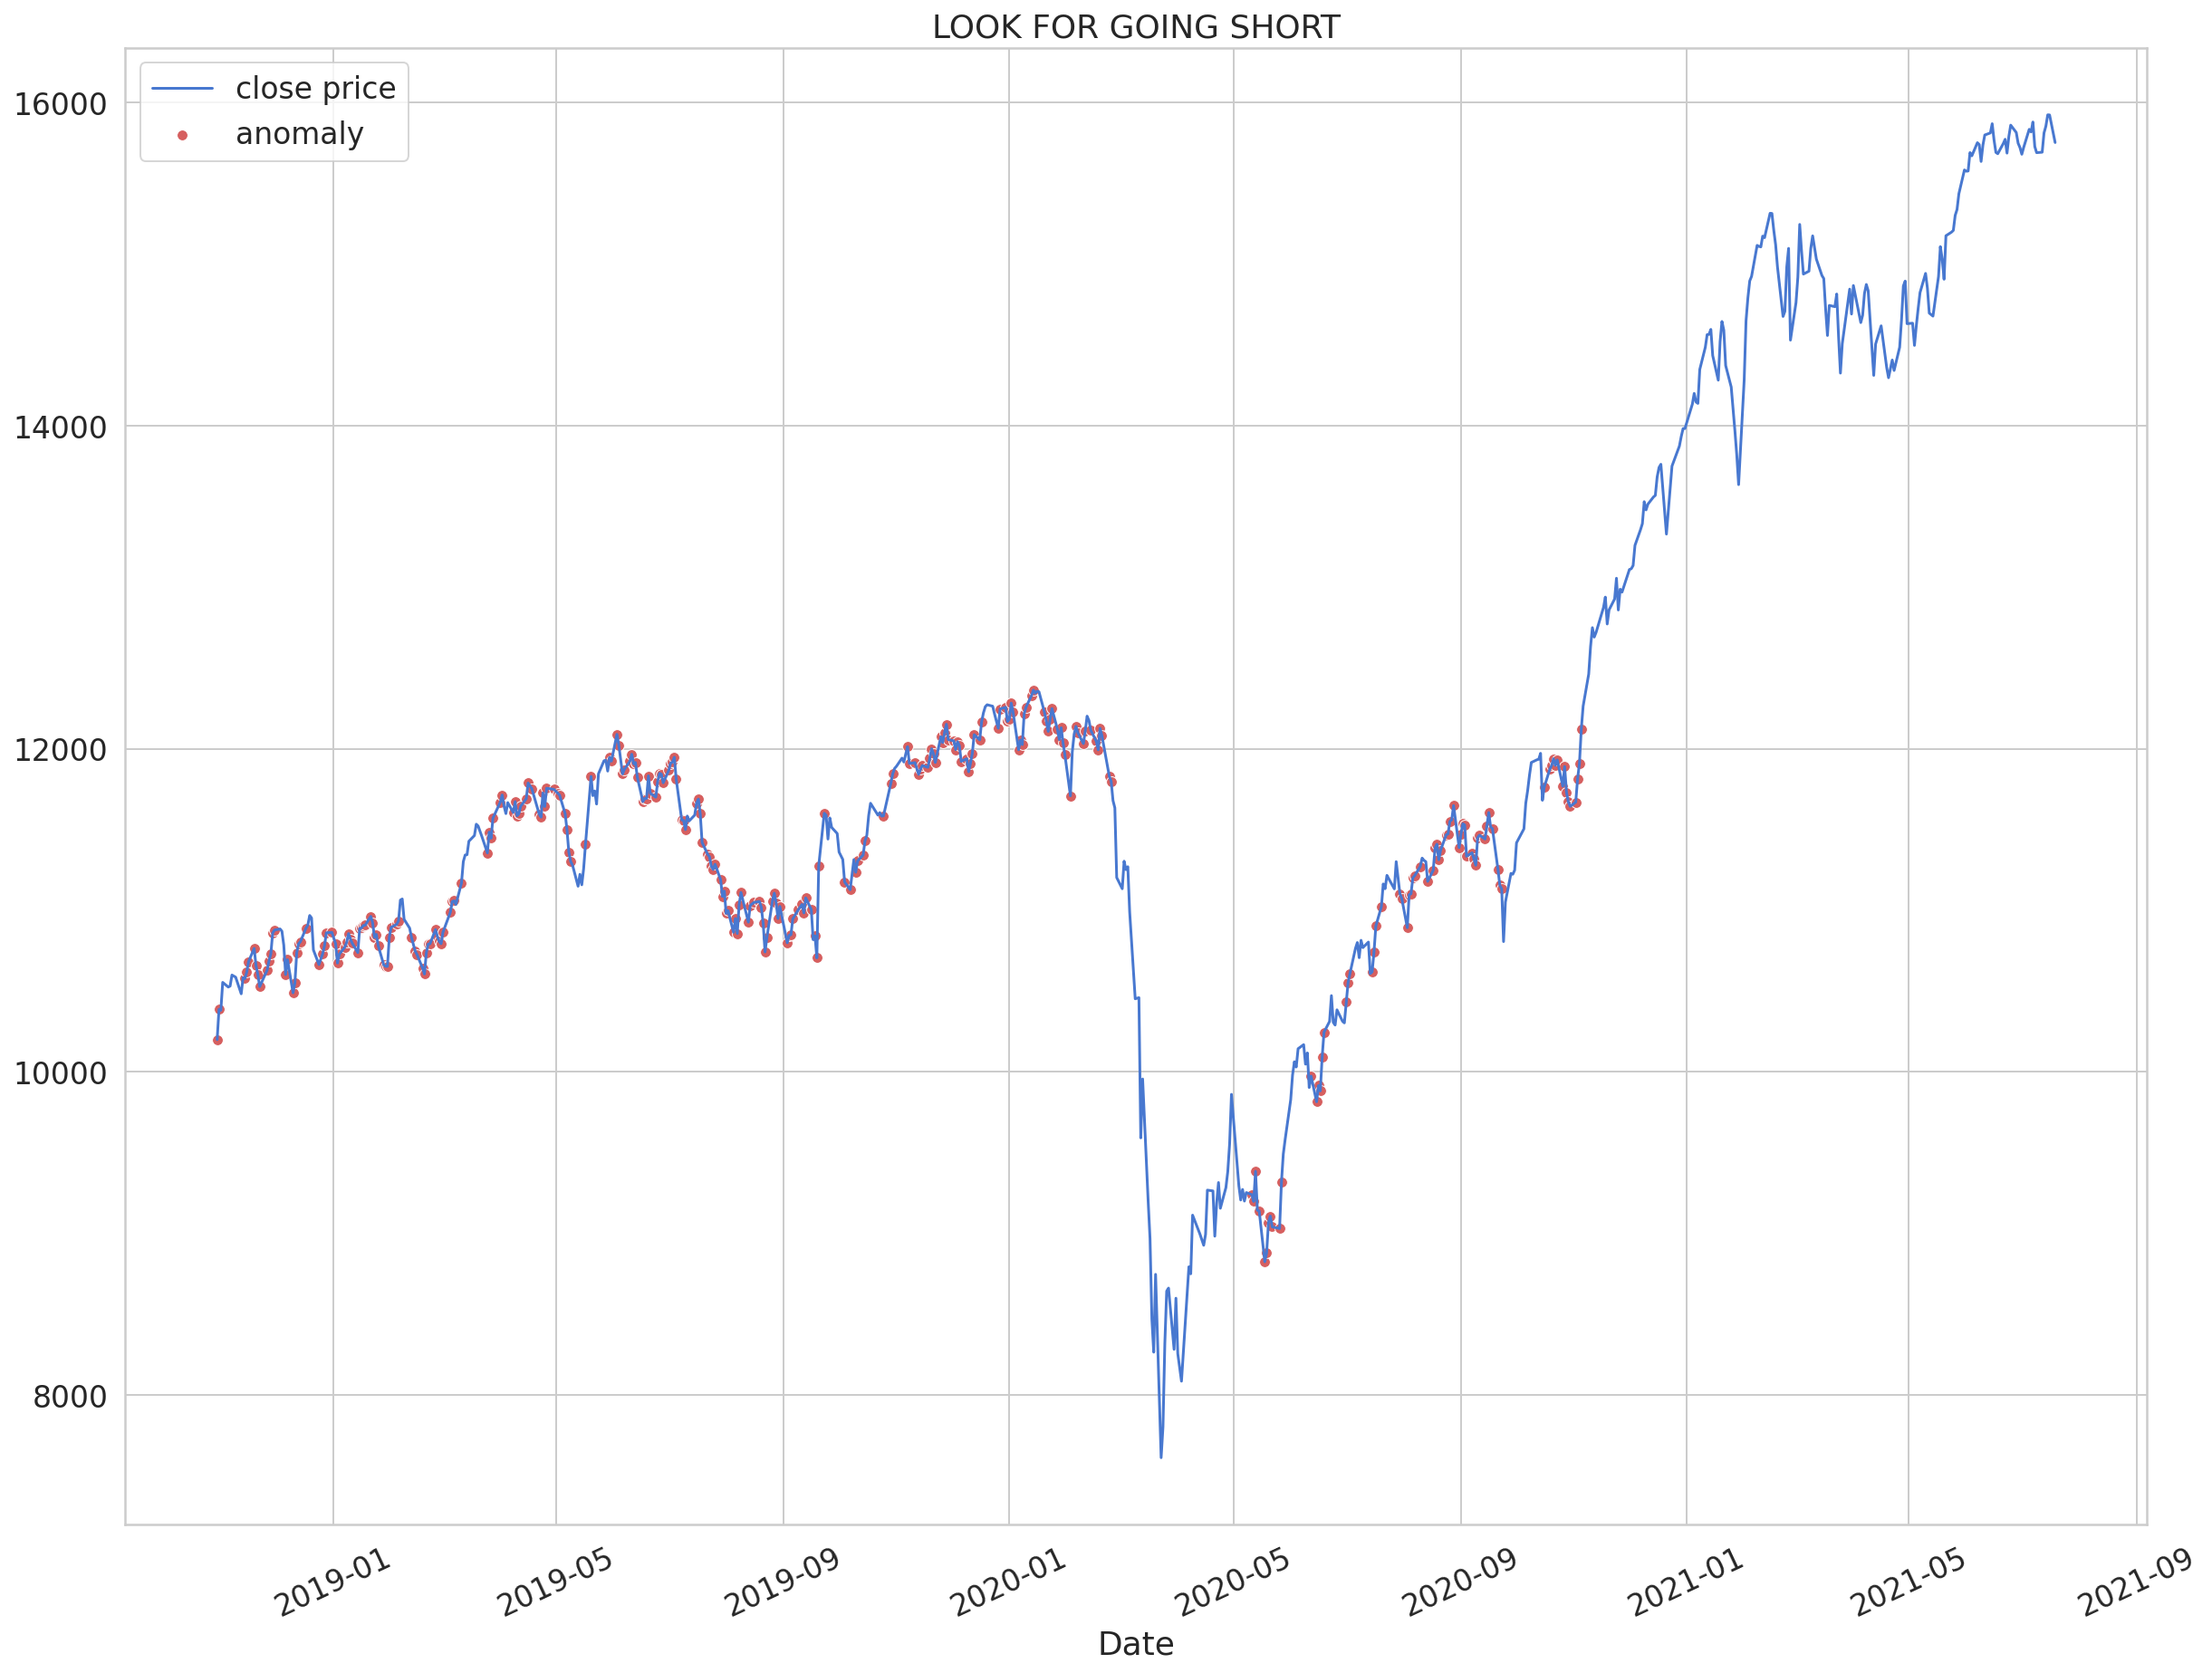

In [43]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
);

sns.scatterplot(
  anomaliesS.index,
  scaler.inverse_transform(anomaliesS.Close),
  color=sns.color_palette()[3],
  s=35,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.savefig('anamolySHORT.png', dpi=150)
plt.title('LOOK FOR GOING SHORT')
plt.legend();